# Module 3 - Algorithm auditing: Accuracy, Fairness and Interpretability 


### Assignment overview

In this assignment, you will be asked to evaluate a set of trained classifiers for accuracy, fairness and transparency. The classifiers have been trained on the [NIJ Recidivism Challenge Dataset](https://nij.ojp.gov/funding/recidivism-forecasting-challenge) to predict whether or not an individual will be arrested for a new crime within 3 years after being released on parole. 

The assignment is modeled after “Accuracy, Fairness, and Interpretability of Machine Learning Criminal Recidivism Models, by Eric Ingram, Furkan Gursoy, Ioannis A. Kakadiaris (https://arxiv.org/abs/2209.14237). 

For this assignment, it is possible to work in **groups of up to 2 students**. Read the instructions carefully, as they may assign tasks to specific students.

### Group members
Leave blanks if group has less than 2 members:
- Student 1: Xueyong Zhang
- Student 2: Yuwen Luo


### Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:
1. Describe different fairness metrics, such as statistical parity, equal opportunity and equal accuracy 
2. Discuss fairness and fairness metrics from the perspective of multiple stakeholders 
3. Define objective functions based on fairness metrics  
4. Evaluate a model’s transparency using strategies such as global surrogate models, permutation feature importance, and Shapley Additive Explanations (SHAP) 
5. Evaluate common machine learning models based on their accuracy, fairness and interpretability 
6. Describe how metrics such as accuracy and fairness need to be balanced for a trained model to have acceptable accuracy and low bias 

## Import Libraries:

In [96]:
# Here are some libraries you may need for this exercise, for your convenience

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    # plot_confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer,
    ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


import joblib
from sklearn import tree
from sklearn.inspection import permutation_importance
# import eli5

import warnings
warnings.filterwarnings("ignore")

# Part 1: Getting started:

Before starting this assignment, we ask you to read the paper it has been modeled after, to get an idea of the problem we are working on: https://arxiv.org/abs/2209.14237

You can also review the original dataset source [here](https://nij.ojp.gov/funding/recidivism-forecasting-challenge). The website includes a lot of information on the dataset and a detailed description of each of its columns (look for Appendix 2: Codebook).

Now that you have familiarized with the problem, you know that the goal is predicting the binary variable `Recidivism_Within_3years`, which indicates whether or not the person has committed a new felony or misdemeanour within 3 years from the beginning of parole supervision. 

The National Institute of Justice’s (NIJ) obviously would want to deploy a highly accurate predictive model, to make sure that only deserving people get released on parole. Unfortunately, the existence of bias in the training set (typically historical or representation bias) makes it very likely to end up with an unfair classifier, that is, a classifier that produces different results for different protected classes of population.

Your job is to evaluate 5 classifiers, pre-trained and provided to you. This is called **algorithm auditing:** you are not the designer of the model, but you are in charge of evaluating its performance. Algorithm auditing can focus on various metrics and populations of interest, but in this case we will focus on evaluating **accuracy, fairness and transparency** of each algorithm.

To begin, load the datasets and classsifiers by running the cells below:

In [97]:
# Note: these training and test sets do not correspond to the ones on the NIJ's website,
# they are our own partition

train_df = pd.read_csv("training_set.csv")
test_df = pd.read_csv("testing_set.csv")

In [98]:
# Creating training and test sets and separating features and target
X_train, y_train = (
    train_df.drop(columns=["Recidivism_Within_3years"]),
    train_df["Recidivism_Within_3years"],
)
X_test, y_test = (
    test_df.drop(columns=["Recidivism_Within_3years"]),
    test_df["Recidivism_Within_3years"],
)

In [99]:
# Loading classifiers
logreg_model  = joblib.load("models_for_A3/NIJ_logreg.joblib")
rf_model      = joblib.load("models_for_A3/NIJ_rf.joblib")
tree_model    = joblib.load("models_for_A3/NIJ_tree.joblib")
xgboost_model = joblib.load("models_for_A3/NIJ_xgboost.joblib")

# Part 2: Classifiers' Accuracy (and other performance metrics):

First, we will evaluate each classifier's accuracy, together with other performance metrics that help us understanding how reliable the classifier's answers are. In addition to accuracy, we will use, **precision, recall, F1 score, and Area Under the Curve (AUC).**

### Question 1

can you provide definition and formula for accuracy, precision, recall and F1 score?

It may help you use this table for reference:

<img src="ConfMatrix.png" alt="drawing" width="500"/>

Here, we are giving you the definition of AUC, as a reminder and example (note that the other metrics will need the formula):

**AUC:** AUC stands for Area Under the ROC curve. The ROC (receiver operating characteristic) curve is a plot of the recall and false positive rate of a classifier for different classification thresholds (see [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) for more details). AUC values go between 0 and 1. Higher values are more desirable as they indicate that the classifier is good at avoiding both false positives and false negatives. A value of 0.5 for a binary classification indicates that the classifier is no better at predicting the outcome than random guessing.

**Add remaining definitions and formulas here**

- **accuracy**：
    - n is the total number of examples
    - ${\text{accuracy}} = \frac{\text{correct predictions}}{\text{total examples}} = \frac{TP + TN}{n} = \frac{TP + TN}{TP+TN+FP+FN}$
    - Accuracy measures the proportion of true results (both true positives and true negatives) among the total number of examples.
- **precision**：
    - $\text{precision} = \frac{TP}{TP+FP}$
    - Precision is the ratio of correctly predicted positive observations to the total predicted positives. It measures the proportion of actual positives among the positive predictions returned by the classifier.
- **recall**：
    - $\text{recall} = \frac{TP}{TP+FN} = \frac{TP}{\#positives}$
    - Recall is the ratio of correctly predicted positive observations to the all observations in the actual class. It measures the proportion of true positive predictions out of all actual positive instances in the dataset. 
- **F1 score**
    - $f1 = 2 \times \frac{ precision \times recall}{precision + recall}$
    - F1 Score is the weighted average (harmonic mean) of Precision and Recall. 

### Question 2

For every classifier given, calculate and report accuracy, precision, recall, F1 score, and AUC on both training and test set. **For ease of visualization, summarize these results in one or two tables below this question.**

**Hints:** 
- Scikit-learn provides a lot of useful built-in functions to compute performance metrics. You can find them all in the package [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics), under Classification Metrics.
- Some classifiers may take longer than others to make their predictions, so you may have to wait a few minutes for a cell to run. More than that, however, likely means something is wrong and needs to be fixed before continuing.

In [100]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    metrics_train = {
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'Precision': precision_score(y_train, y_train_pred),
        'Recall': recall_score(y_train, y_train_pred),
        'F1 Score': f1_score(y_train, y_train_pred),
        'AUC': roc_auc_score(y_train, y_train_prob)
    }
    metrics_test = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1 Score': f1_score(y_test, y_test_pred),
        'AUC': roc_auc_score(y_test, y_test_prob)
    }
    print("Training Set Results:")
    print(metrics_train)

    print("\nTest Set Results:")
    print(metrics_test)

### LogReg Model:

In [101]:
evaluate_model(logreg_model, X_train, y_train, X_test, y_test)

Training Set Results:
{'Accuracy': 0.714609599646096, 'Precision': 0.7761194029850746, 'Recall': 0.7163214896446893, 'F1 Score': 0.7450224791265253, 'AUC': 0.785838297959206}

Test Set Results:
{'Accuracy': 0.7019739388466004, 'Precision': 0.7493970091654607, 'Recall': 0.7096847875742348, 'F1 Score': 0.7290004692632568, 'AUC': 0.7733865131928679}


### Random Forest Model:

In [102]:
evaluate_model(rf_model, X_train, y_train, X_test, y_test)

Training Set Results:
{'Accuracy': 0.9966268524662685, 'Precision': 0.9993319973279893, 'Recall': 0.9948698460953829, 'F1 Score': 0.9970959295405856, 'AUC': 0.9999245055414643}

Test Set Results:
{'Accuracy': 0.7192620307057154, 'Precision': 0.7212620578778135, 'Recall': 0.819780721790772, 'F1 Score': 0.7673722471669874, 'AUC': 0.7747274766956633}


### Decision Tree Model:

In [103]:
evaluate_model(tree_model, X_train, y_train, X_test, y_test)

Training Set Results:
{'Accuracy': 0.7386087148860871, 'Precision': 0.7618058690744921, 'Recall': 0.8015390461713852, 'F1 Score': 0.7811675385398825, 'AUC': 0.8100348249928842}

Test Set Results:
{'Accuracy': 0.6978454392981551, 'Precision': 0.7135963071758288, 'Recall': 0.7768387391502969, 'F1 Score': 0.7438757655293088, 'AUC': 0.7535380592692054}


### XGBoost Model:

In [104]:
evaluate_model(xgboost_model, X_train, y_train, X_test, y_test)

Training Set Results:
{'Accuracy': 0.8735899137358991, 'Precision': 0.8672014260249554, 'Recall': 0.92437773133194, 'F1 Score': 0.8948772187988595, 'AUC': 0.9489406817690109}

Test Set Results:
{'Accuracy': 0.7359050445103857, 'Precision': 0.7372277630775493, 'Recall': 0.8273184102329831, 'F1 Score': 0.7796792594984393, 'AUC': 0.8096944103857562}


### Question 3

For every classifier given, plot the confusion matrices on training and test set. Here is another function you will find helpful for this task: [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [105]:
def plot_confusion_matrices(model, model_name, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'{model_name} - Training Set Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'{model_name} - Test Set Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()


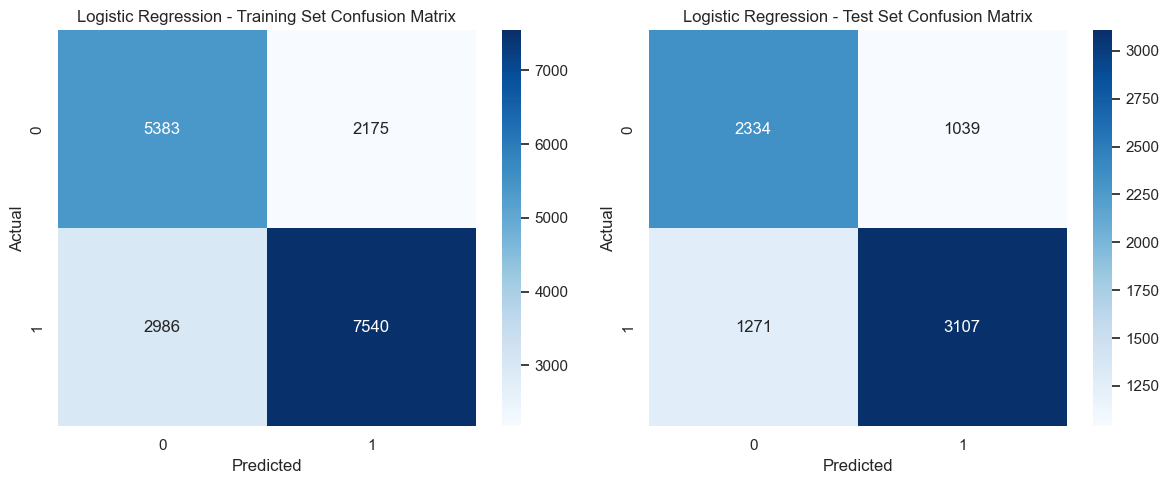

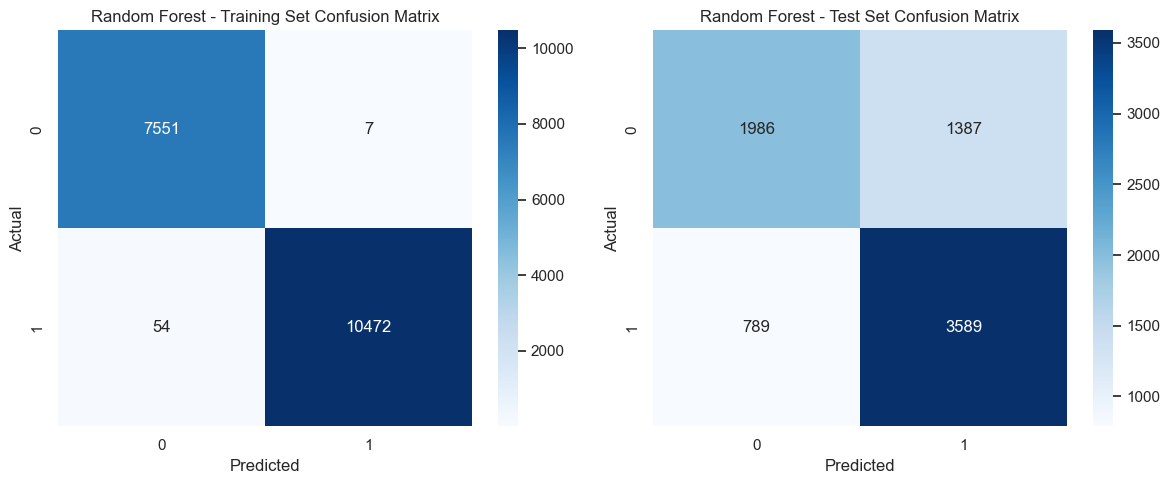

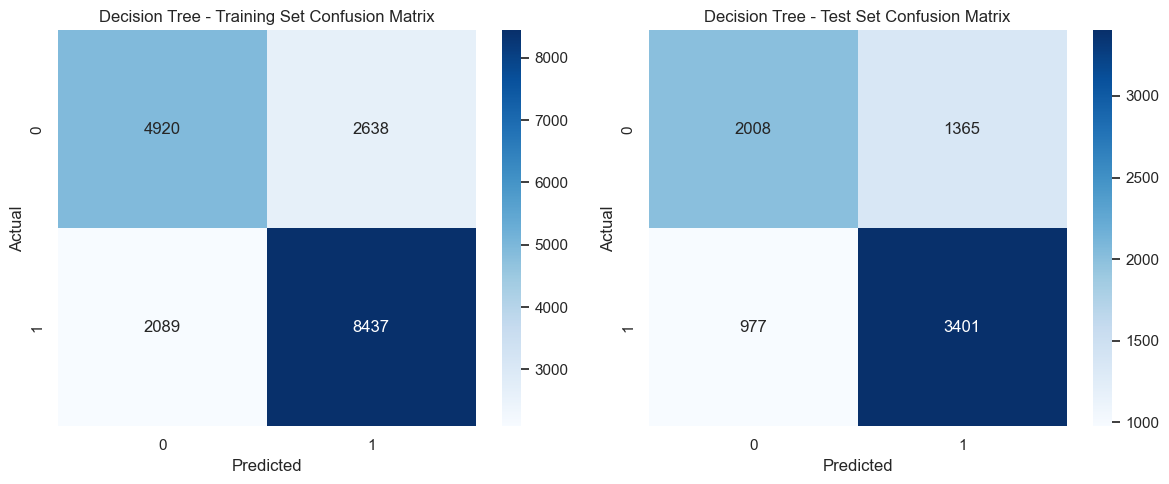

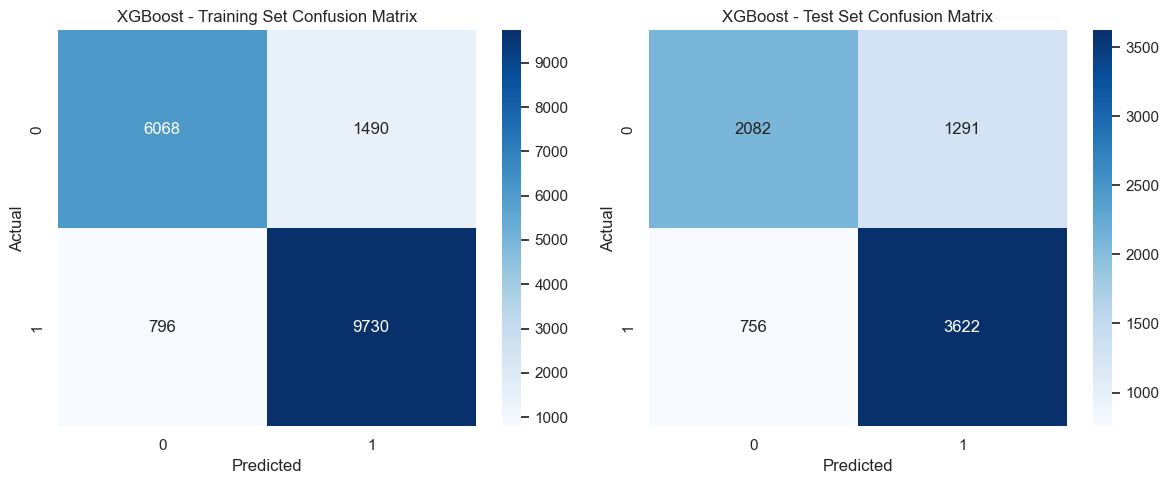

In [106]:
models = {
    "Logistic Regression": logreg_model,
    "Random Forest": rf_model,
    "Decision Tree": tree_model,
    "XGBoost": xgboost_model
}
for model_name, model in models.items():
    plot_confusion_matrices(model, model_name, X_train, y_train, X_test, y_test)

### Question 4

Based on the results obtained so far, answer the following questions, providing an explanation and trying to base your decision on multiple metrics:
- Which classifiers would you choose for deployment?
- Which classifier is the most "severe" (a.k.a. classifies more people as at risk of committing another crime within 3 years)?
- Which classifier is the most cautious (a.k.a. classifies less people as at risk of committing another crime within 3 years)?

1. Choice for Deployment: I would select the XGBoost model for deployment. This model exhibits the highest test accuracy, recall, F1 score, and AUC, indicating its superior overall performance in distinguishing between classes compared to the other models. Most importantly, its high recall is particularly relevant for this task. Since we aim to minimize the risk of releasing individuals who may commit crimes again, it is critical to prioritize capturing as many true positives as possible, even at the expense of some false positives. This approach ensures that the potential societal harm of releasing a former offender is mitigated.

2. Most "Severe" Classifier: According to the metrics calculated, the XGBoost model is the most "severe" classifier. It have the highest TP and number positives, so it is more likely to predict positive(committing another crime within 3 years in this case). And its high recall value on the test set reflects a tendency to classify a greater number of individuals as at risk of recidivism within three years. This characteristic aligns with the goal of identifying individuals who may pose a risk to society.

3. Most Cautious Classifier: Based on the calculated metrics, the Logistic Regression model appears to be the most cautious classifier. It have the most TN and FN. A cautious model typically predicts more negative instances, thereby reducing the risk of incorrectly labeling someone as likely to reoffend.

# Part 3 :  Fairness Evaluation:

Now that we have an understanding of how accurate our classifiers are across all samples, we need to measure their *fairness* across different categories. In similar problems, we are typically concerned with the classifiers being fair across different segments of protected populations (e.g. different genders or ethnicities). The original paper evaluates fairness for both gender and race, but for the purpose of this exercise we will only look at fairness across race, that is, for White and Black defendants.

### Question 5

As we have seen in class, there is not just one fairness metric, but several, as they have different ways to identify different treatments across populations. The metrics used in the paper, which you will have to replicate, are:

1. *Predicted Positive Rate Disparity (PPRD)*, whether the numbers of positive predictions are on par across groups.
2. *Predicted Positive Group Rate Disparity (PPGRD)*, whether the rates of positive predictions are on par across groups.
3. *False Discovery Rate Disparity (FDRD)*, whether the ratios of false positives to predicted positives are on par across groups.
4. *False Positive Rate Disparity (FPRD)*, whether the ratios of false positives to actual negatives are on par across groups.
5. *False Omission Rate Disparity (FORD)*, whether the ratios of false negatives to predicted negatives are on par across groups.
6. *False Negative Rate Disparity (FNRD)*, whether the ratios of false negatives to actual positives are on par across groups.

Before jumping into code writing, we must make sure that we have a solid understanding of how these metrics are computed from the True Positive, True Negative, False Positive, and False Negative values *for each group*. We will add the subscript *b* and *w* when appropriate to identify metrics from the group of black or white defendants, respectively. Then, we will write the equations for all fairness metrics. The first one is provided to you as an example:

| Metric    | Formula |
| :-------- | :------- |
| PPRD  |  (TPb + FPb) / (TPw + FPw)  |
| PPGRD |  ((TPb + FPb) / (TPb + FPb + TNb + FNb)) / ((TPw + FPw) / (TPw + FPw + TNw + FNw))|
| FDRD |   (FPb / (TPb + FPb)) /  (FPw / (TPw + FPw))|
| FPRD |   (FPb / (TNb + FPb)) / (FPw / (TNw + FPw))|
| FORD |   (FNb / (TNb + FNb)) / (FNw / (TNw + FNw))|
| FNRD |   (FNb / (TPb + FNb)) / (FNw / (TPw + FNw))|

Finally, the paper also computes an **Average Distance from Reference** across all the above metrics. This helps us summarizing the fairness of a classifier in a single number. Compute the Average Distance from Reference for all the classifiers, knowing that the reference is 1 (i.e. a score of 1 indicates perfect fairness). Use tha absolute value to compute the distance from the reference (e.g. a FDRD score of 0.80 and one of 1.20 both have a distance from the reference of 0.20).

Now that you have a better understanding of how to compute these metrics, do so for all the classifiers, both on the training and the test sets.

**Hints:**
- There are several ways to write Python code to easily compute the fairness metrics we want. If you have trouble starting, talk with a TA or with the instructor during our in-class work time or office hours to come up with a plan. 
- Instead of copy-pasting code, it is definitely a good idea to create one or more functions to compute the fairness metrics. Writing functions in Python is very easy! If you are new to it, start [here](https://www.geeksforgeeks.org/python-functions/) (stop before Arbitrary Keyword Arguments), and of course, come to us for more help!

In [107]:
classifiers_dict = {
    'Logistic Regression': logreg_model,
    'Random Forest': rf_model,
    'Decision Tree': tree_model,
    'XGBoost': xgboost_model
}

def get_group_confusion_matrix(y_true, y_pred, groups, group_b, group_w):
    cm_b = confusion_matrix(y_true[groups == group_b], y_pred[groups == group_b])
    cm_w = confusion_matrix(y_true[groups == group_w], y_pred[groups == group_w])
    return cm_b, cm_w

def compute_fairness_metrics(cm_b, cm_w):
    tp_b, fp_b, tn_b, fn_b = cm_b.ravel()
    tp_w, fp_w, tn_w, fn_w = cm_w.ravel()
    pprd = (tp_b + fp_b) / (tp_w + fp_w)
    ppgrd = (tp_b + fp_b) / (tp_b + fp_b + tn_b + fn_b) / ((tp_w + fp_w) / (tp_w + fp_w + tn_w + fn_w))
    fdrd = (fp_b / (tp_b + fp_b)) / (fp_w / (tp_w + fp_w))
    fprd = (fp_b / (tn_b + fp_b)) / (fp_w / (tn_w + fp_w))
    ford = (fn_b / (fn_b + tn_b)) / (fn_w / (fn_w + tn_w))
    fnrd = (fn_b / (tp_b + fn_b)) / (fn_w / (tp_w + fn_w))
    return {"PPRD": pprd, "PPGRD": ppgrd, "FDRD": fdrd, "FPRD": fprd, "FORD": ford, "FNRD": fnrd}

fairness_metrics_train = {}
fairness_metrics_test = {}

for classifier_name, classifier in classifiers_dict.items():
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)

    cm_b_train, cm_w_train = get_group_confusion_matrix(y_train, y_train_pred, train_df['Race'], "BLACK", "WHITE")
    cm_b_test, cm_w_test = get_group_confusion_matrix(y_test, y_test_pred, test_df['Race'], "BLACK", "WHITE")

    fairness_metrics_train[classifier_name] = compute_fairness_metrics(cm_b_train, cm_w_train)
    fairness_metrics_test[classifier_name] = compute_fairness_metrics(cm_b_test, cm_w_test)


train_fairness_df = pd.DataFrame(fairness_metrics_train)
test_fairness_df = pd.DataFrame(fairness_metrics_test)

In [108]:
print("Fairness Metrics for Training Set")
train_fairness_df

Fairness Metrics for Training Set


,Logistic Regression,Random Forest,Decision Tree,XGBoost
PPRD,1.271716,1.271716,1.271716,1.271716
PPGRD,0.947284,0.947284,0.947284,0.947284
FDRD,1.213997,1.965847,1.225651,1.320936
FPRD,1.098880,1.312500,1.115687,1.150027
FORD,1.024787,0.998612,1.034386,1.017415
FNRD,1.085136,1.039669,1.090897,1.070936


In [109]:
print("\nFairness Metrics for Test Set")
test_fairness_df


Fairness Metrics for Test Set


,Logistic Regression,Random Forest,Decision Tree,XGBoost
PPRD,1.294558,1.294558,1.294558,1.294558
PPGRD,0.943702,0.943702,0.943702,0.943702
FDRD,1.166160,1.179099,1.213249,1.109142
FPRD,1.048899,1.076623,1.087179,0.999265
FORD,1.014773,1.031623,1.031879,0.999451
FNRD,1.083227,1.093034,1.103695,1.062909


### Question 6

Based on the results obtained so far, answer the following questions, providing an explanation for each answer:
- Which model exhibits the least amount of bias? 
- Which one is the worse?
- Based on the application, which fairness metric(s) do you think should be the most important? Which one(s) could be taken less into consideration?
- Finally, based on the fairness results, which model would you pick for this application? 

1. XGBoost exhibits the least amount of bias. In general, except PPRD and FDRD, all other metrics both on test and training sets are close to 1(have difference less than 0.2). And there are also some metrics have the lowest difference among other models. First, it has the lowest FDRD on the test set (1.109142), which indicates it has less disparity in the rate of false positives across different groups compared to other models. Second, it has the lowest FPRD (0.999265), which indicates that it has a more balanced false positive rate across different groups compared to the other classifiers. It also has a FORD close to 1 (0.999451 on the test set), indicating a balanced false omission rate across groups.
2. The Decision Tree model seems to exhibit the most bias. First, it has the highest FDRD on both the training set (1.225651) and the test set (1.213249), meaning there is significant disparity in the rate of false positives between groups. Second, it also has the highest FNRD on the test set (1.103695), which shows that the model has a notable disparity in how it handles false negatives across groups.
3. In the context of predicting recidivism, FNRD and FDRD are the most important metrics because a high rate of false negative and false positive means certain groups may disproportionately be classified as low-risk when they are actually high-risk and in another way around. This will lead to serious fairness issue because certain group will have unfair punishment or denial of parole even though they don't deserve it while the other group tend to be easy to be being released while they are actually dangerous. However, PPRD can be taken less into consideration because the dataset itself don't have same amount of sample for both groups. The data itself don't have statistical parity will lead to PPRD not par even if there i sno fiarness issue with the model.
4. Base on the fairness results, I will pick the XGBoost model. It exhibits the least amount of bias across multiple fairness metrics (particularly FDRD, FPRD, and FORD) on both training and test sets, while still maintaining high accuracy and recall. This makes it the most balanced model for both fairness and performance, ensuring that it does not disproportionately predict specific groups while still being effective in predicting recidivism.

# Part 4: Interpretability Evaluation:

Finally, we will evaluate the *interpretability* of our models. It is important to be able to explain how the model uses each feature to make its predictions and *why* a model has given a particular response for an individual - especially important when, like in this case, people's lives are being affected.

### Inherently Interpretable Models

Some models are known to be *inherently interpretable*, meaning we can decifer the model behavior by looking at its parameters. These models are also called "white-box" models. Logistic regression models and decision trees - in some cases - fall in this category.

### Question 7

Run the cells below and look at the weights of the logistic regression model. For simplicity, the cells below show the 10 most positive and 10 most negative coefficients. What features bring the prediction more toward the positive class? What other features push the prediction toward the negative class? Do you see any coefficients that may be unfairly influencing the decision?

In [110]:
feature_names = np.array(logreg_model.named_steps['columntransformer'].get_feature_names_out())
coeffs = logreg_model.named_steps["logisticregression"].coef_.flatten()
coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)

In [111]:
coeff_df_sorted.head(10)

,Coefficient
pipeline-2__Gang_Affiliated_True,0.777355
pipeline-2__Age_at_Release_18-22,0.769491
pipeline-2__Delinquency_Reports_1,0.635838
pipeline-2__Age_at_Release_23-27,0.488772
pipeline-2__Prior_Arrest_Episodes_Felony_0,0.473405
pipeline-2__Gender_M,0.458260
passthrough__Prior_Revocations_Parole,0.362398
passthrough__Condition_MH_SA,0.359117
pipeline-1__Jobs_Per_Year,0.312944
pipeline-2__Prison_Years_Less than 1 year,0.307459


In [112]:
coeff_df_sorted.tail(10)

,Coefficient
pipeline-2__Delinquency_Reports_3,-0.205489
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0,-0.216048
pipeline-2__Age_at_Release_38-42,-0.235466
pipeline-2__Prior_Arrest_Episodes_Felony_2,-0.249548
pipeline-2__Age_at_Release_43-47,-0.350821
pipeline-2__Program_Attendances_10 or more,-0.385809
pipeline-2__Prior_Arrest_Episodes_Felony_1,-0.501982
pipeline-2__Delinquency_Reports_4 or more,-0.507616
pipeline-1__Percent_Days_Employed,-0.663686
pipeline-2__Age_at_Release_48 or older,-0.752269


1. What features bring the prediction more toward the positive class? 

Individuals marked as **Gang Affiliation (True)**; **Age at Release between 18-22 and 23-27**; **Males**; **Prior Arrests (Felony 0)**: no prior felony arrests; and **Delinquency Reports (1)** are more likely to be predicted as recidivists (the positive class).

2. What other features push the prediction toward the negative class? 

Individuals with these features: **Age at Release (48 or older)** and also the **relased age between 43-47**, **Percent Days Employed**, **Delinquency Reports (4 or more)**, and **Prior Arrest Episodes (Felony, 1)**, are less likely to be classified as recidivists.

3. Do you see any coefficients that may be unfairly influencing the decision?
- Gender (Male): This feature's impact might reflect from historical data that could introduce gender bias and also societal bias. It’s essential to check if this disparity unfairly penalizes individuals based on their gender.
- Gang Affiliation: While gang affiliation can be a factor in predicting recidivism, it’s worth questioning whether this feature could disproportionately affect certain racial or socioeconomic groups. If gang affiliation is overrepresented among specific groups, this could lead to biased predictions.
- Age at Release (18-22, 23-27): Penalizing someone purely for their age could be seen as unfair, while it shows statistically that younger age groups are more likely to recidivate, it’s crucial to ensure that this is based on solid evidence rather than a discriminatory assumption. 

### Question 8

Now, let's look at a particular sample and try to explain its prediction. We have picked this sample because its feature values make it a hard case, one very close to the threshold between positive and negative class:

In [113]:
hard_sample = X_test[106:107]
hard_sample

,Unnamed: 0,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,...,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
106,5645,5788,F,WHITE,48 or older,3,NaN,6.0,High,At least some college,...,NaN,NaN,NaN,0.596215,2.0,False,False,False,False,0


If you look at the ground truth for this sample (try `y_test[106:107]`) you will see that this person has not, in fact, committed a new crime within 3 years from release. But what is the prediction of the logistic regression model? Find the answer and comment below:

In [114]:
# Your answer here
print("Ground truth (actual outcome):", y_test[106:107])

print("prediction for LogReg model: ", logreg_model.predict(hard_sample))
print("LogReg model Prediction probabilities (Negative class, Positive class):", logreg_model.predict_proba(hard_sample))

Ground truth (actual outcome): 106    False
Name: Recidivism_Within_3years, dtype: bool
prediction for LogReg model:  [False]
LogReg model Prediction probabilities (Negative class, Positive class): [[0.74498534 0.25501466]]


From the output above, the logistic regression model predicts made the correct prediction that the person did not commit a new crime within 3 years of release.

Take a closer look at the feature values for this sample. What seems to have contributed the most to the final prediction? What feature pushed the most in the opposite direction?

In [115]:
transformed_sample = logreg_model.named_steps['columntransformer'].transform(hard_sample).flatten()
coeffs = logreg_model.named_steps["logisticregression"].coef_.flatten()
weighted_values = transformed_sample * coeffs

feature_contributions = pd.DataFrame({
    'Feature': feature_names,
    'Transformed Feature Value': transformed_sample,
    'Coefficient': coeffs,
    'Contribution': weighted_values
})

feature_contributions_sorted = feature_contributions.sort_values(by="Contribution", ascending=False)

print("Top positive contributions:")
print(feature_contributions_sorted.head(5).to_string(index=False))
print("\nTop negative contributions:")
print(feature_contributions_sorted.tail(5).to_string(index=False))


Top positive contributions:
                                             Feature  Transformed Feature Value  Coefficient  Contribution
                           pipeline-1__Jobs_Per_Year                   1.536636     0.312944      0.480881
                        passthrough__Condition_MH_SA                   1.000000     0.359117      0.359117
pipeline-2__Prior_Arrest_Episodes_Property_5 or more                   1.000000     0.148764      0.148764
pipeline-2__Prior_Conviction_Episodes_Prop_3 or more                   1.000000     0.116480      0.116480
            pipeline-2__Prior_Arrest_Episodes_Drug_3                   1.000000     0.103483      0.103483

Top negative contributions:
                                                  Feature  Transformed Feature Value  Coefficient  Contribution
                  pipeline-2__Program_UnexcusedAbsences_0                   1.000000    -0.110286     -0.110286
passthrough__Prior_Conviction_Episodes_PPViolationCharges                   1

1. What seems to have contributed the most to the final prediction?
- **pipeline-1__Jobs_Per_Year** contributes most to the model’s final prediction towards the positive class (recidivism). The more jobs per year, the higher the likelihood of recidivism within 3 years.

2. What feature pushed the most in the opposite direction?
- **pipeline-2__Age_at_Release_48 or older** pushed the prediction towards the negative class (no recidivism), making it the most important factor in the opposite direction. This aligns with the general trend that older individuals are less likely to recidivate.

### Question 9
We said that decision trees are also inherently interpretable - *potentially*. That is because, in theory, it is possible to look at the tree structure and to follow the path along the tree to see how each node influenced the decision. But this is only possible if the tree has a reasonably small size.

Run the cell below and see if you can tell what are the most influencial features in the decision tree model.

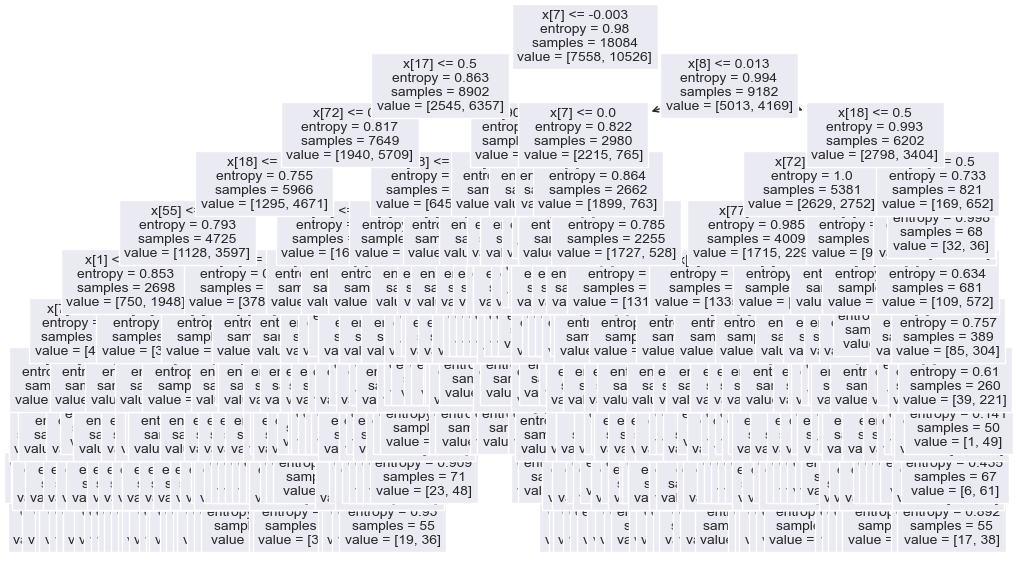

<Figure size 1000x600 with 0 Axes>

In [116]:
tree.plot_tree(tree_model["dt"],fontsize=10)
plt.figure(figsize=(10,6))
plt.show()

The decision tree plot above is difficult to interpret due to its complexity. The decision trees above are deep and has too many splits that overlapped together, making it less interpretable. <br>
One thing can read from the plot is that the root node `x[7]` is the most influential feature because it has been used to make the first split, indicating it affects the largest number of samples.

If the method above was not satisfactory, you can try visualizing all the rules of the decision tree as text. Is this any better?

In [117]:
from sklearn.tree import export_text
tree_rules = export_text(tree_model.named_steps['dt'], feature_names=list(tree_model.named_steps['ct'].get_feature_names_out()))
print(tree_rules)

|--- pipeline-1__Percent_Days_Employed <= -0.00
|   |--- pipeline-2__Age_at_Release_48 or older <= 0.50
|   |   |--- pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0 <= 0.50
|   |   |   |--- pipeline-2__Gang_Affiliated_True <= 0.50
|   |   |   |   |--- pipeline-2__Prior_Arrest_Episodes_Misd_6 or more <= 0.50
|   |   |   |   |   |--- pipeline-1__Supervision_Risk_Score_First <= 0.20
|   |   |   |   |   |   |--- pipeline-1__Percent_Days_Employed <= -1.15
|   |   |   |   |   |   |   |--- pipeline-2__Gender_M <= 0.50
|   |   |   |   |   |   |   |   |--- pipeline-2__Residence_Changes_0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |--- pipeline-2__Residence_Changes_0 >  0.50
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- pipeline-2__Gender_M >  0.50
|   |   |   |   |   |   |   |   |--- pipeline-2__Prior_Conviction_Episodes_Prop_0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- pipeline-2__Prior_Arre

From the text version, we can see that the first few lines of the rules, which are important features in this decision tree include:
Percent_Days_Employed, which appears at the root of the tree; 
Age_at_Release_48 or older, and  making Prior_Arrest_Episodes_PPViolationCharges_0 which are used in the upper parts of the tree indicates they are highly influential.
But it does not do much better than the plot since it's still hard to read the complex structure of the indented text to identify features.


When it is not possible to interpret a decision tree because of its complex structure, we can still extract other information from it that will help us understand the features' importance in the decision. The code in the cell below extracts the feature importances from the model (line 3), then uses this information to create a bar plot of features sorted by importance. The feature importance extracted this way is based on [Gini Importance](https://www.codecademy.com/article/fe-feature-importance-final) (as it is done in the original paper), which reflects how the features were picked when building the decision tree.

<Axes: >

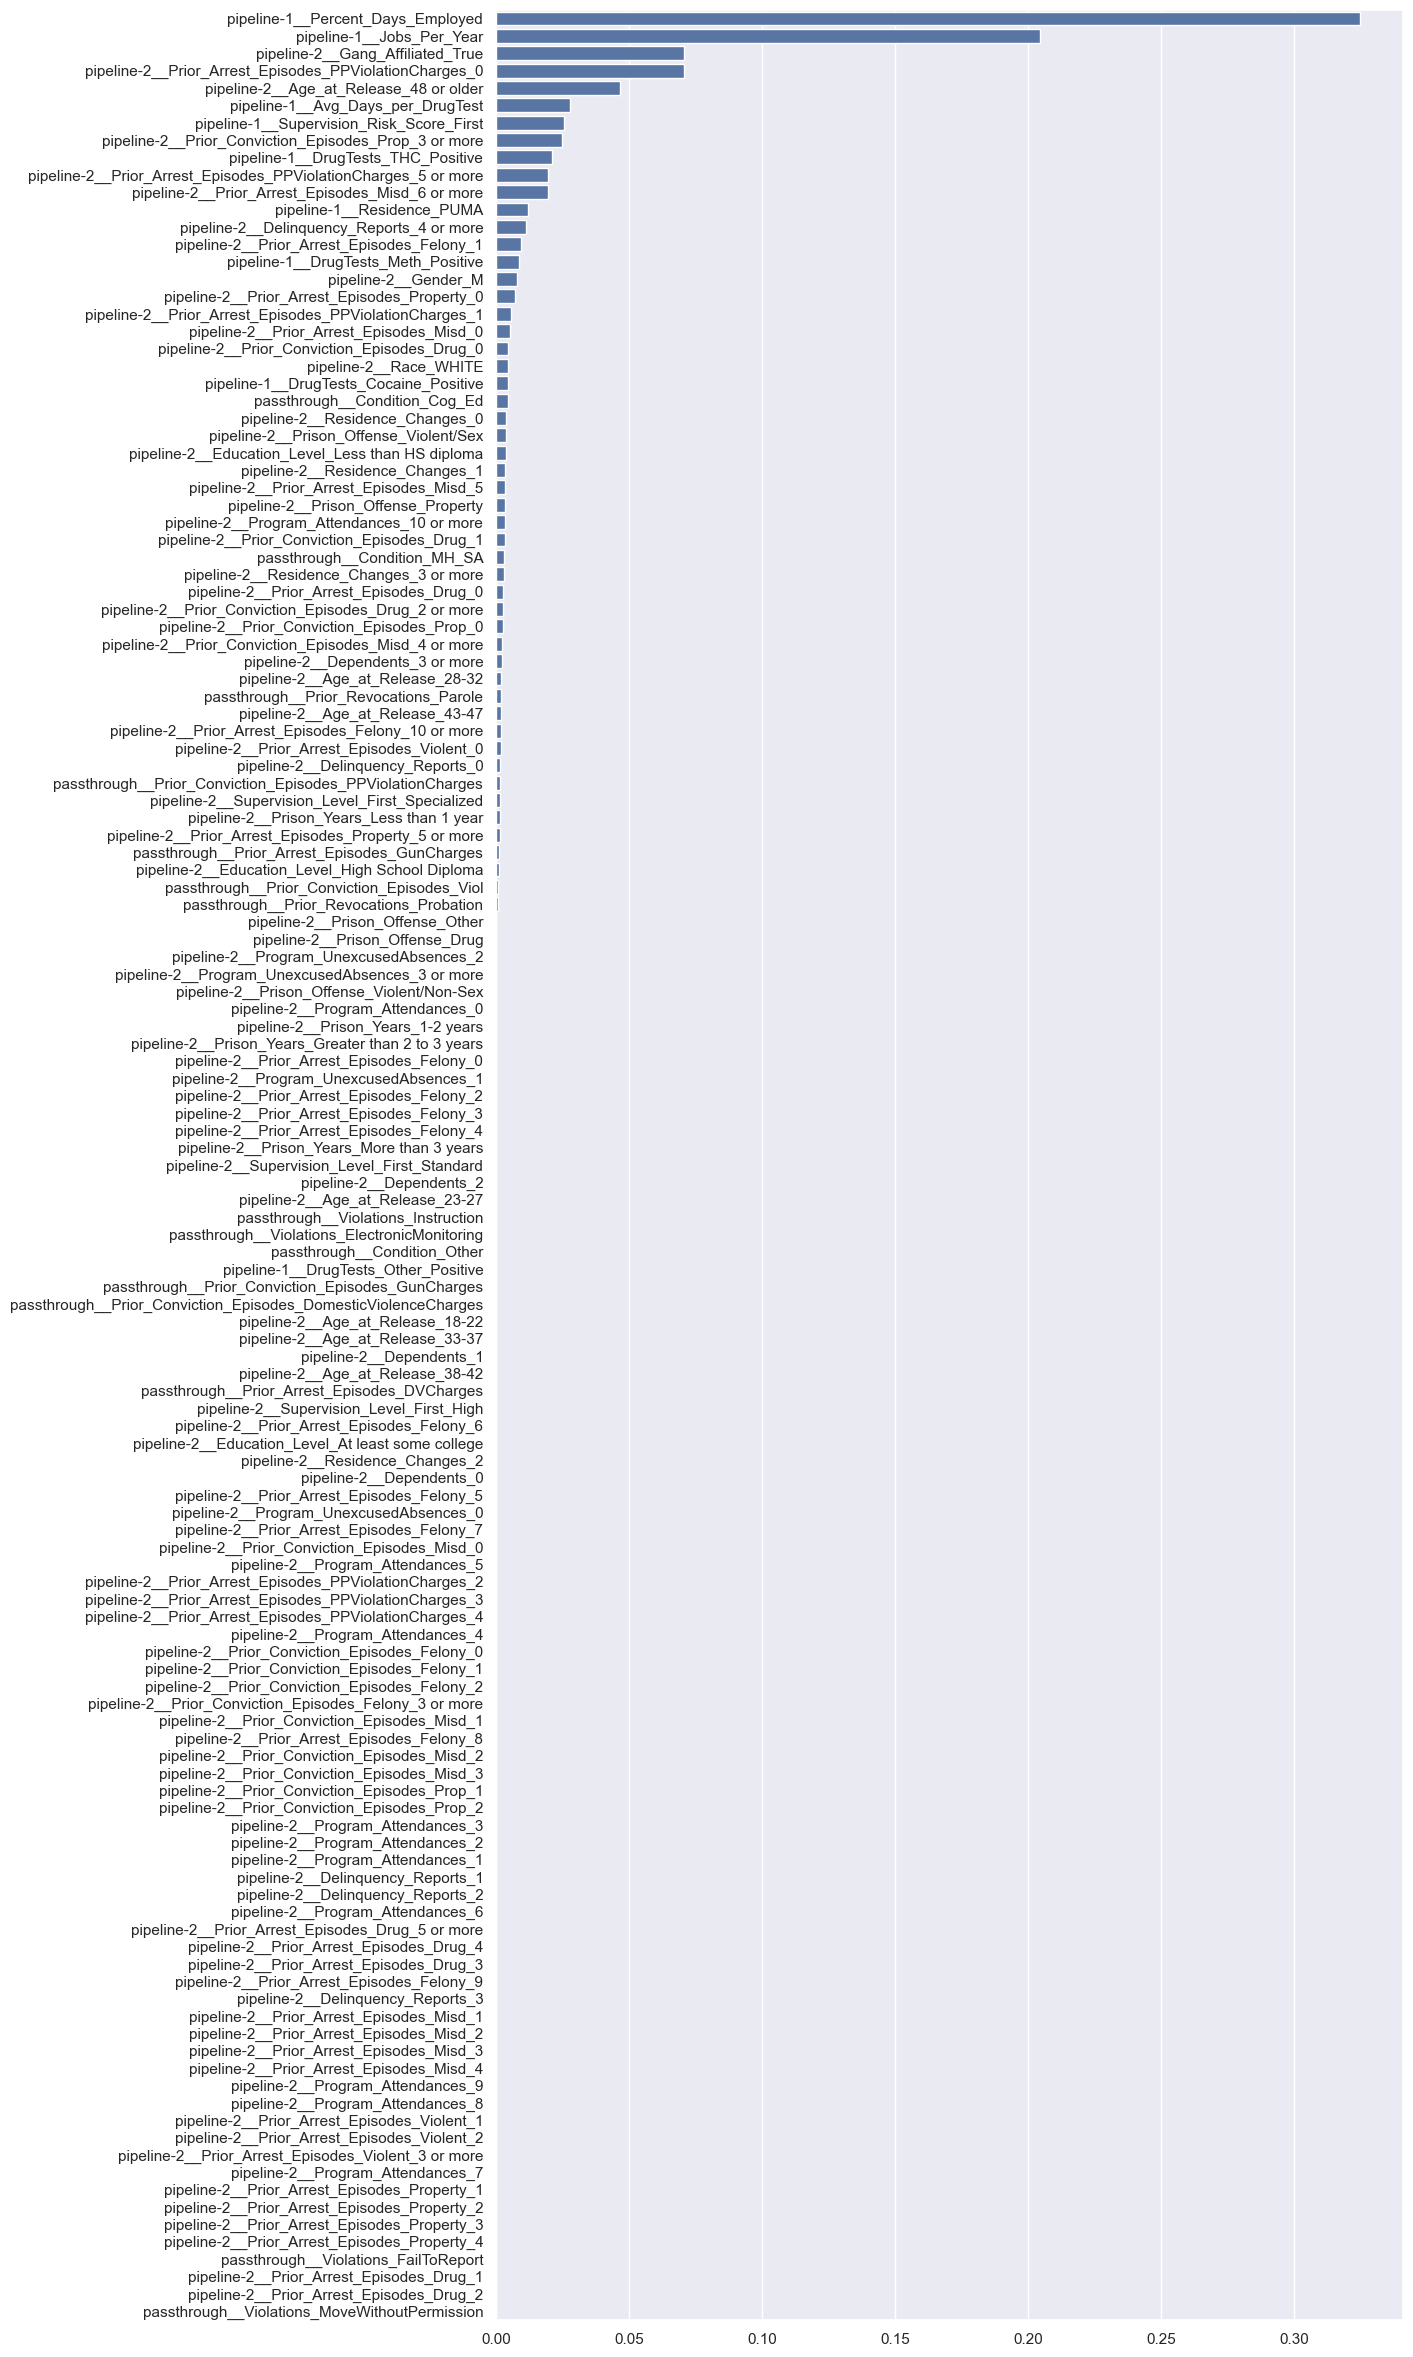

In [118]:
import seaborn as sns

feature_importances = tree_model.named_steps["dt"].feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = tree_model.named_steps['ct'].get_feature_names_out()[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)

Comment on the features importance of the tree model, compared to those seen in the logistic regression model, as well as the original paper results. Also, **what is a big limitation of using feature importance, compared to observing the coefficient of the logistic regression model?**

From the bar plot of feature importances, pipeline-1__Percent_Days_Employed is the most important feature.
Other important features include:
pipeline-1__Jobs_Per_Year,
pipeline-2__Gang_Affiliated_True,
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0, and pipeline-2__Age_at_Release_48 or older.
<br>
Both the decision tree and logistic regression models emphasize pipeline-1__Percent_Days_Employed as the most important feature. In the logistic regression model, it has a strong negative coefficient, indicating that increased employment days reduce the likelihood of recidivism, which is intuitive. Similarly, in the decision tree model, it remains the most critical feature.
pipeline-2__Age_at_Release_48 or older is also influential in both models, though it shows a more negative impact in the logistic regression model. Other features like Jobs_Per_Year and Delinquency_Reports_4 or more appear in both models, reflecting their consistent importance.
However, some features like Gang_Affiliated_True and Prior_Arrest_Episodes_Misd/Felony are more critical in the decision tree than in logistic regression, indicating differing interpretations between models.
Compared to the original paper, the decision tree also shows employment and age as influencial features, reaffirming their impact in predicting outcomes. However Gang_Affiliated_True feature being more significant in the paper's results. 

The limitation of feature importance in decision trees is that it tells us which features are used most often to split the data and which features are most influential in making predictions, but not how the feature affects the prediction outcome. Compared to the coefficient of the logistic regression model, the coefficents tells the strength of the impact (absolute value of the coeff) and also the direction of the impact (posotively or negatively related to the target value). Thus the feature importance for the tree model is less interpretable.

### Question 10

As before, we are interested in evaluating how the model classifies a particular sample. Let's start looking at the classification for our `hard_sample`. Is it correct?

In [119]:
# Your answer here
hard_sample = X_test[106:107]
ground_truth = y_test[106:107]
print("Ground truth:", ground_truth.values[0])

# Make a prediction using the decision tree model
tree_prediction = tree_model.predict(hard_sample)
print("Decision Tree Prediction:", tree_prediction[0])

# Compare the prediction with the ground truth
if tree_prediction == ground_truth.values[0]:
    print("The decision tree model's prediction is correct.")
else:
    print("The decision tree model's prediction is incorrect.")


Ground truth: False
Decision Tree Prediction: True
The decision tree model's prediction is incorrect.


We would like to be able to tell what sequence of rules has led to this final decision, but, for a tree this large, this can be difficult, unless we want to manually sift through the list of rules or write some elaborate custom code. In the next sections, we will see an alternative method (SHAP) to achieve this result.

### Question 11: Evaluation of Non-inherently Interpretable Models Using a Surrogate Model

Models that are not inherently interpretable ("black box" models) can still be examined to understand how they used the available features to make their predictions. In fact, there are many strategies to do this. The first one we are going to see is through use of a **surrogate model.** In this case, we train another model - an inherently interpretable one, such as a logistic regressor - on the *predictions* of the black box model, and then we try to interpret *its parameters*. Let's complete the code below to do that on the two non-inherently interpretable models included in this exercise: the Random Forest and XGBoost.

#### Surrogate for Random Forest Model

In [120]:
# Step 1: create logistic regressor object.
# For simplicity, we will use the already existing "NIJ_logreg.joblib" and re-train it, instead of creating
# a new one. The reason for this decision is that NIJ_logreg.joblib already knows how to handle the features
# of this dataset, while a new one will need to be designed to do so.

surrogate_model_rf = joblib.load("models_for_A3/NIJ_logreg.joblib")

# Step 2: train model on random forest predictions on the training set
rf_predictions_train = rf_model.predict(X_train)
surrogate_model_rf.fit(X_train, rf_predictions_train)

# Step 3: visualize weights of surrogate model, as we did for the original logistic regression model
feature_names = np.array(surrogate_model_rf.named_steps['columntransformer'].get_feature_names_out())
coeffs = surrogate_model_rf.named_steps["logisticregression"].coef_.flatten()
coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)
print("Top 10 positive coefficients:")
print(coeff_df_sorted.head(10))
print("\nTop 10 negative coefficients:")
print(coeff_df_sorted.tail(10))

Top 10 positive coefficients:
                                              Coefficient
pipeline-2__Age_at_Release_18-22                 0.796636
pipeline-2__Gang_Affiliated_True                 0.790565
pipeline-2__Delinquency_Reports_1                0.650981
pipeline-2__Prior_Arrest_Episodes_Felony_0       0.489534
pipeline-2__Age_at_Release_23-27                 0.488824
pipeline-2__Gender_M                             0.446960
passthrough__Prior_Revocations_Parole            0.370422
passthrough__Condition_MH_SA                     0.357176
pipeline-1__Jobs_Per_Year                        0.319845
passthrough__Violations_ElectronicMonitoring     0.319349

Top 10 negative coefficients:
                                                    Coefficient
pipeline-2__Delinquency_Reports_3                     -0.204958
pipeline-2__Prior_Arrest_Episodes_PPViolationCh...    -0.230000
pipeline-2__Age_at_Release_38-42                      -0.238056
pipeline-2__Prior_Arrest_Episodes_Felony_2   

Now that we have the weights of the surrogate model, what can we say about how the Random Forest model makes its predictions? What features seem more important? Are they similar to what we have seen for the other models so far?

- What can we say about how the Random Forest model makes its predictions: <br>
Random Forest model makes predictions based on the voting or averaging of many decision trees, it's an ensemble of decision trees. <br>

- What features seem more important? Are they similar to what we have seen for the other models so far? <br>
From the results above, Age_at_Release_18-22 and Gang_Affiliated_True are the two most positively influential features. This indicates that younger individuals (ages 18-22) and those affiliated with gangs are more likely to be classified as recidivists by the Random Forest model.
Age_at_Release_48 or older is the most negatively influential feature, suggesting that older individuals are less likely to be classified as recidivists by the Random Forest model, consistent with both the logistic regression model and decision tree model.
Percent_Days_Employed also has a strong negative influence, meaning that more days employed reduces the likelihood of recidivism, which aligns with what we have seen in the previous models.
Criminal history features like Delinquency_Reports_4 or more and Prior_Arrest_Episodes_Felony_1 also reduce the likelihood of recidivism, further highlighting the importance of prior criminal records.
These influencial features show consistent importance across all models (logistic regression, decision tree, and Random Forest), while the relative importance and ranking of these features may vary slightly across models.

**Note:** using a surrogate model is not always a very good strategy, because the simpler "white box" model is often unable to replicate the behavior of the most complex "black box" model. We can get a sense of how close the surrogate is approximating the original model by looking at the R<sup>2</sup> score. In the paper, they do so when trying to create a surrogate for XGBoost, and they explain: 

*The R<sup>2</sup> value between the XGBoost predictions and the surrogate model predictions on the test set is 0.38. The surrogate model only explains 38% of the variance in the XGBoost model’s predictions*

Test this for the random forest surrogate model. How much variance is it able to capture?

**Hints:**
- Think carefully about what constitues the array of predictions and the array of ground truths in this case
- You may remember that R<sup>2</sup> is, in fact, a metric for regression, not for classification! How can we use R<sup>2</sup> in this case? There are various ways to approximate R<sup>2</sup> for classification, as explained [here](https://datascience.oneoffcoder.com/psuedo-r-squared-logistic-regression.html). We will use the simplest one and use **count R<sup>2</sup>**, which is simply the accuracy of the surrogate classifier

In [121]:
# Your answer here

rf_predictions_test = rf_model.predict(X_test)
surrogate_predictions_test = surrogate_model_rf.predict(X_test)
r2_count = accuracy_score(rf_predictions_test, surrogate_predictions_test)
r2_count

0.8307315185137402

Now, repeat the analysis through surrogate model for XGBoost. Comment on the results, including considerations on the following:
- What seem to be the most important features?
- How do the sets of most important features compare across models (do not forget logistic regression and decision tree in this comparison)?
- How good are the surrogate models, in terms of capturing the variance of the original model? Are they reliable?
- ...more thoughts of your choice...

#### Surrogate for XGBoost Model

In [122]:
# Step 1: XGBoost model 
surrogate_model_xgb = joblib.load("models_for_A3/NIJ_logreg.joblib")

# Step 2: train model on XGBoost predictions on the training set
xgboost_predictions_train = xgboost_model.predict(X_train)
surrogate_model_xgb.fit(X_train, xgboost_predictions_train)

# Step 3: visualize the weights of the surrogate model
feature_names = np.array(surrogate_model_xgb.named_steps['columntransformer'].get_feature_names_out())
coeffs = surrogate_model_xgb.named_steps["logisticregression"].coef_.flatten()
coeff_df_xgb = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
coeff_df_xgb_sorted = coeff_df_xgb.sort_values(by="Coefficient", ascending=False)

print("Top 10 positive coefficients for XGBoost surrogate:")
print(coeff_df_xgb_sorted.head(10))
print("\nTop 10 negative coefficients for XGBoost surrogate:")
print(coeff_df_xgb_sorted.tail(10))

# count R^2  between XGBoost and surrogate model predictions on the test set
xgboost_predictions_test = xgboost_model.predict(X_test)
surrogate_predictions_test_xgb = surrogate_model_xgb.predict(X_test)
r2_count_xgb = accuracy_score(xgboost_predictions_test, surrogate_predictions_test_xgb)
print("\n", r2_count_xgb)


Top 10 positive coefficients for XGBoost surrogate:
                                                    Coefficient
pipeline-2__Age_at_Release_18-22                       1.344978
pipeline-2__Gang_Affiliated_True                       1.322722
pipeline-2__Gender_M                                   0.939579
pipeline-2__Delinquency_Reports_1                      0.853040
pipeline-2__Age_at_Release_23-27                       0.767391
pipeline-2__Prior_Arrest_Episodes_Felony_0             0.668435
passthrough__Condition_MH_SA                           0.643236
pipeline-2__Prior_Arrest_Episodes_Felony_10 or ...     0.606695
pipeline-2__Prison_Years_Less than 1 year              0.591937
passthrough__Violations_ElectronicMonitoring           0.589145

Top 10 negative coefficients for XGBoost surrogate:
                                                    Coefficient
pipeline-2__Prison_Years_Greater than 2 to 3 years    -0.373178
pipeline-2__Prior_Arrest_Episodes_Felony_2            -0.378917

- Most Important Features in the XGBoost Surrogate model:
Age_at_Release_18-22 and Gang_Affiliated_True are the most positively influential features in the XGBoost surrogate, much like in the Random Forest surrogate. 
Gender_M, Delinquency_Reports_1, and Prior_Arrest_Episodes_Felony_0 also significantly contribute to the positive class prediction.
Percent_Days_Employed and Age_at_Release_48 or older are the most negatively influential features, Prior_Arrest_Episodes_Felony_1 and Delinquency_Reports_4 or more also play strong roles in pushing the prediction toward the negative class. These features have been consistently important across all models.

- Comparison Across Models:
Across all models (logistic regression, decision tree, Random Forest, and XGBoost), age and employment remain the most critical features. Gang affiliation and criminal history are also crucial in influencing recidivism predictions across all models. Older individuals (48+ years) and those with high employment tend to have a lower likelihood of recidivism.
While all models agree on the importance of certain key features like employment and age, the exact ranking and strength of influence vary, Some features that play important roles in one model may be less prominent in others. For example, in XGBoost, Gender_M is highly influential, while in Random Forest, Jobs_Per_Year was more influential.

- How good are the surrogate models:
The high R^2 for XGBoost suggests that the surrogate model is quite reliable for interpreting XGBoost in this case and indicates that it approximates the behavior of XGBoost very well.

### Question 12: Evaluation of Non-inherently Interpretable Models Using Permutation Feature Importance

Another method used to interpret black box models is using feature permutation, which means changing the value of a feature and observing changes in the model's prediction error. More important features, when changed, will result in more frequent mistakes.

Luckily for us, Permutation Feature Importance already exists as a function in Scikit-Learn! All you have to do it is looking at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) to learn how it works, and apply it to the 3 non-inherently interpretable models of this exercise. Let's start with Random Forest.

#### Random Forest Model:

In [123]:
# Use permutation_importance on the random forest model, and save the result in a variable called "out"
out = permutation_importance(rf_model, X_test, y_test, random_state=0)

After you are done, you can run the cell below to visualize the top 5 most important features in a bar chart. If you like, you can change the number of features shown or try other visualization methods.

<Axes: xlabel='Importance', ylabel='Name'>

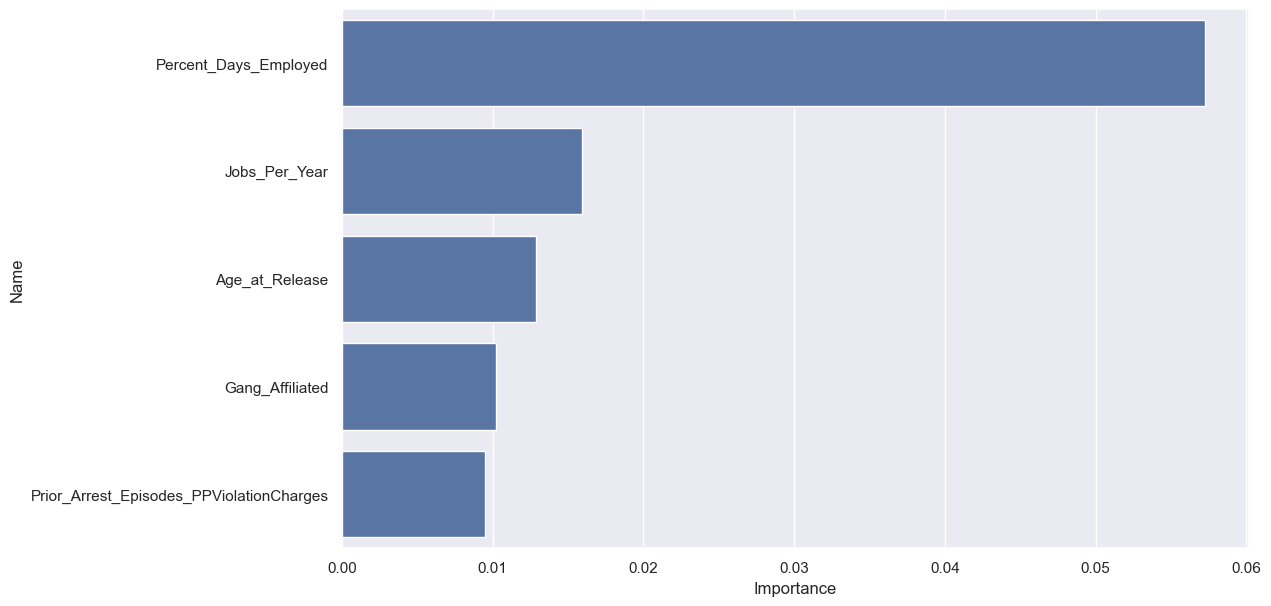

In [124]:
result = pd.DataFrame({"Name": X_test.columns, "Importance": out["importances_mean"], "STD": out["importances_std"]})
result = result.sort_values(by=['Importance'], ascending=False)

sns.set(rc={'figure.figsize':(11.7,7)})
sns.barplot(data=result[:5], y="Name", x="Importance")

Now, use Permutation Feature Importance on XGBoost.

**Hint:** this is a more complex model; if you find that this task is taking too long, you may consider reducing the number of permutations using the parameter `n_repeats`. Be aware that this produces more variable results.

#### XGBoost Model:

<Axes: xlabel='Importance', ylabel='Name'>

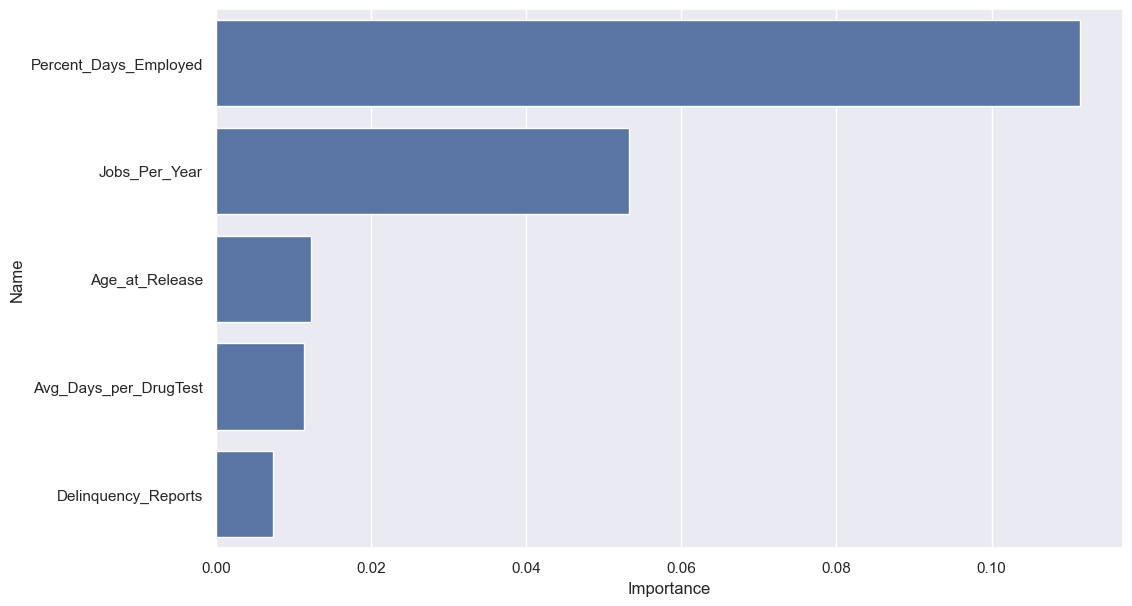

In [125]:
out_xgb = permutation_importance(xgboost_model, X_test, y_test, n_repeats=5, random_state=0)

result = pd.DataFrame({"Name": X_test.columns, "Importance": out_xgb["importances_mean"], "STD": out_xgb["importances_std"]})
result = result.sort_values(by=['Importance'], ascending=False)

sns.set(rc={'figure.figsize':(11.7,7)})
sns.barplot(data=result[:5], y="Name", x="Importance")

Now that you have completed your analysis of feature importance using permutation, comment on the results. How do the sets of most important features compare with each other? Are this results similar to what you observed using the surrogate model?

The top 5 most important features from the XGBoost model using permutation importance are: Percent_Days_Employed,Jobs_Per_Year, Age_at_Release, Avg_Days_per_DrugTest, and Delinquency_Reports.
The Random Forest model most important features are: Percent_Days_Employed, Jobs_Per_Year, Age_at_Release, Gang_Affilated and Prior_Arrest_Episodes_. 

These three features: Percent_Days_Employed, Jobs_Per_Year, and Age_at_Release consistently appeared in all the models we analyzed. Avg_Days_per_DrugTest appears as a top feature in the permutation importance analysis for XGBoost model but was not as prominent in the random forest model. This indicates that permutation importance might capture more subtle interactions in XGBoost model. The ranking and specific contributions of some features may differ slightly between the surrogate model and permutation importance.

### Question 13: Evaluation of Non-inherently Interpretable Models Using SHAP

The last method we are going to use to interpret the impact of each feature in our model is called SHAP, which stands for SHapley Additive exPlanations. How SHAP works is beyond the scope of this course, but if you are curious you can read the [original paper](https://arxiv.org/pdf/1705.07874.pdf) by Lundberg and Lee and check out [Lundberg's GitHub repo](https://github.com/shap/shap), which provides details on the implementation and examples.

You will need to install SHAP to be able to use it:
```
pip install shap
or
conda install -c conda-forge shap
```

Then, import it:

In [126]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [127]:
import shap # downgrade numpy to version = 1.23
shap.initjs()

SHAP needs the model (we will start with Random Forest) and samples to use to explain the predictions. For this, we will need to give it transformed samples (scaled and imputed, as required by the model) from  `X_train` or `X_test`.

In [128]:
X_train_enc = pd.DataFrame(
    data=rf_model.named_steps['ct'].transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=rf_model.named_steps['ct'].transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

ind = np.random.choice(len(X_test_enc) - 1, 1000)  
# This line just gives 1000 random indexes from the training set
# We do this because getting SHAP values for all samples would be a bit too long, but you 
# are free to try it out!

ind = np.append(ind, 106) # adding the hard sample - we'll need this later

The following lines are all that's needed to explain the model's predictions for a set of samples:

In [129]:
rf_explainer = shap.Explainer(rf_model[-1])  # creating SHAP Explainer based on the model

rf_shap_values = rf_explainer.shap_values(X_test_enc.iloc[ind])  # explaining predictions for 1000 random samples

This gives us the SHAP values for each sample and each feature (the index 1 indicates the positive class):

In [130]:
rf_shap_values[1]

array([[-9.50703894e-03,  9.50703894e-03],
       [-2.13308288e-03,  2.13308288e-03],
       [ 2.31797869e-03, -2.31797869e-03],
       [-2.12025369e-02,  2.12025369e-02],
       [ 4.50208730e-03, -4.50208730e-03],
       [ 8.00513473e-03, -8.00513473e-03],
       [ 4.75092784e-03, -4.75092784e-03],
       [ 2.53407298e-02, -2.53407298e-02],
       [ 2.99106434e-02, -2.99106434e-02],
       [-4.52605028e-03,  4.52605028e-03],
       [ 5.93626350e-03, -5.93626350e-03],
       [ 5.20307170e-03, -5.20307170e-03],
       [ 9.14865055e-03, -9.14865055e-03],
       [ 3.49384611e-03, -3.49384611e-03],
       [ 1.18868627e-03, -1.18868627e-03],
       [-8.56398606e-04,  8.56398606e-04],
       [-9.07366656e-04,  9.07366656e-04],
       [-8.39869045e-03,  8.39869045e-03],
       [ 1.67104752e-02, -1.67104752e-02],
       [ 2.21956554e-03, -2.21956554e-03],
       [ 5.27216778e-04, -5.27216778e-04],
       [ 6.36639636e-03, -6.36639636e-03],
       [-2.22377798e-03,  2.22377798e-03],
       [-4.

This is hardly interpretable, though. It is better to get the average values for each feature, which returns something similar to feature importance:

In [131]:
values = np.abs(rf_shap_values[:,:,1]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False)[:10]

,SHAP
pipeline-1__Percent_Days_Employed,0.073883
pipeline-2__Gang_Affiliated_True,0.028394
pipeline-1__Supervision_Risk_Score_First,0.024601
pipeline-1__DrugTests_THC_Positive,0.024226
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0,0.021070
pipeline-1__Jobs_Per_Year,0.021028
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_5 or more,0.016686
pipeline-2__Age_at_Release_48 or older,0.015200
pipeline-2__Prior_Conviction_Episodes_Misd_0,0.013166
pipeline-2__Prior_Arrest_Episodes_Property_0,0.012458


The SHAP library also has a lot of ways to visualize and interpret the SHAP values - try it out!

In [132]:
rf_shap_values[1].shape

(133, 2)

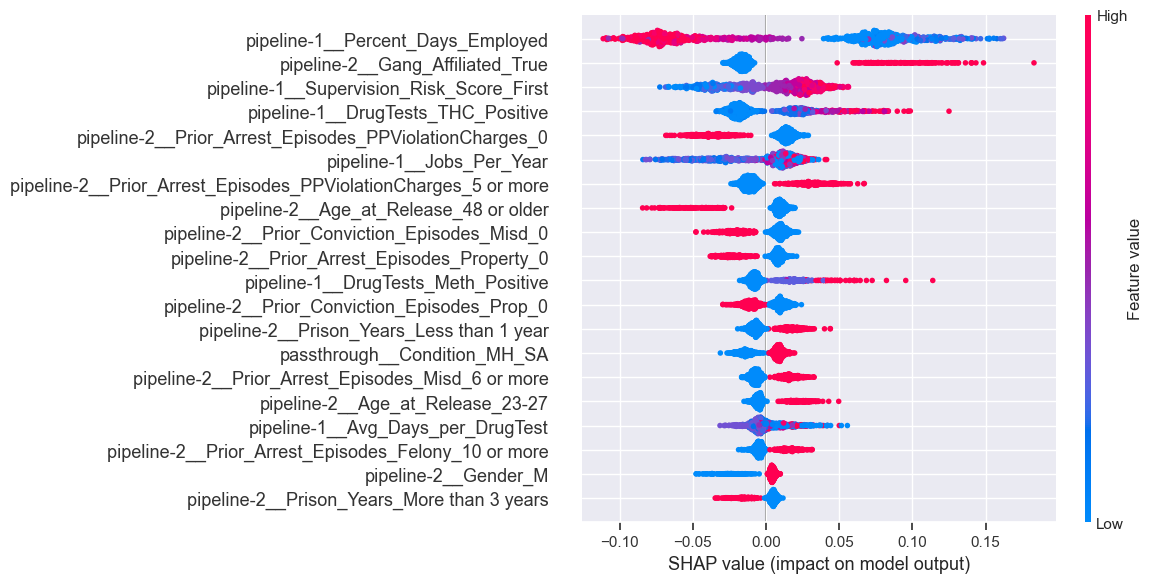

In [133]:
shap_figure = shap.summary_plot(rf_shap_values[:,:,1], X_test_enc.iloc[ind], plot_size=[12,6])

Given the new information obtained using the SHAP library on the Random Forest model, explain the results (you will need to refer to the SHAP documentation - or ask us for help interpreting the plots) and comment on the difference between these results and those obtained using the other methods.


#### We can see on the plot, for Random Forest model:

Low value of `Percent_Days_Employed`, true value of `Gang_Affiliated` `DrugTests_THC_Positive` `Prior_Arrest_Episodes_PPViolationCharges_5 or more` `DrugTests_Meth_Positive` are the value of features that have large positive SHAP value, referring to SHAP documentation, it means those specific value of features have a big impact on the model to push it's prediction more towards positive class(which is recidivism). 

High value of `Percent_Days_Employed`, low value of `Supervision_Risk_Score_First` `Jobs_Per_Year`, true value of `Prior_Arrest_Episodes_PPViolationCharges_0` `Age_At_Release_48_or_older` `Prior_Conviction_Episodes_Misd_0` `Prior_Arrest_Episodes_Property_0` `Prison_Years_More than 3 years`, false value of `Gender_M` are the value of features that have large negative SHAP value, referring to SHAP documentation, it means those specific value of features have a big impact on the model to push it's prediction more towards negative class(which is no recidivism). 

In particularly, `Percent_Days_Employed` and `Gang_Affiliated` are two most important features in the model because their distinct value(low and high or true or false) are scattered at either high SHAP value or low SHAP value oppositely, which means their value difference can make both big negative and positive impact on the model prediction.

Other features value are more concentrate near 0, which means they have relatively small SHAP value. This indicate the value change in those features only bring little impact on model's prediction. So those features are less important for the model.

#### Difference between these results and those obtained using the other methods:

Compared to the result from surrogate models. First, because the model is like logistic regression, which can assign coefficients to features regardless of the scale of the feature value, so each feature can have a number whose positive or negative suggest the direction of the relationship and indicate the feature importance. However, the number cannot represent how much impact will it brings to the model. On the other hand, the result from SHAP(SHAP value) capture the alteration of prediction for each feature's increment or decrement so that we can tell how much the model output will effected by the feature.

Second, result from SHAP also provide a more detailed and thorough demonstration because we can see the impact difference for both high(true) or low(false) value. For example, for `DrugTests_Meth_Positive`, we can see clearly it's true value can push the prediction more towards positive. However, it's false value doesn't bring much negative impact on the model, and some even bring small positive impact on the model. On the other hand, result from surrogate model don't have that detailed demonstration for each feature.


Next, **repeat this analysis for XGBoost.**

In [134]:
X_train_enc = pd.DataFrame(
    data=xgboost_model.named_steps['ct'].transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=xgboost_model.named_steps['ct'].transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

ind = np.random.choice(len(X_test_enc) - 1, 1000)  
ind = np.append(ind, 106) 

xgb_explainer = shap.Explainer(xgboost_model[-1])  
xgb_shap_values = xgb_explainer.shap_values(X_test_enc.iloc[ind])

xgb_shap_values[1]

array([-1.2625843e-01, -1.1163119e-01, -1.6637984e-01,  8.9658305e-02,
       -2.5020216e-02, -4.2938814e-02, -1.9696228e-02,  6.4571929e-01,
       -8.9898638e-02,  3.2806948e-02, -6.4087324e-02, -1.6039522e-02,
        2.8133109e-01, -1.9127483e-02,  1.3135372e-02,  1.8097477e-02,
        6.5835635e-04,  2.8331265e-02, -5.6626368e-02,  9.2757018e-03,
       -1.2204373e-02,  6.2213503e-02,  3.8806021e-03,  1.0360089e-01,
        1.8117984e-04,  4.2612545e-02,  3.6054395e-02, -1.2913626e-02,
       -5.0371587e-03,  1.7837198e-04,  4.9468060e-03,  3.4543208e-04,
        4.1119054e-02,  3.4362497e-04, -6.6878451e-03,  2.3900669e-02,
       -3.2322057e-02, -6.3600168e-02, -7.7930809e-04, -1.9443671e-01,
       -2.5895782e-02,  1.0200081e-03,  1.6877709e-02, -1.4171467e-02,
        2.9807973e-03, -1.3308529e-02,  3.6771561e-03, -1.0718888e-02,
       -2.3285602e-03,  2.0287713e-02,  5.9611914e-03,  1.2932706e-02,
        1.1948651e-02, -1.5089300e-02,  3.8089138e-04, -6.3408010e-02,
      

In [135]:
values = np.abs(xgb_shap_values).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False)[:10]

,SHAP
pipeline-1__Percent_Days_Employed,0.766921
pipeline-1__Jobs_Per_Year,0.485549
pipeline-2__Gang_Affiliated_True,0.205205
pipeline-1__Avg_Days_per_DrugTest,0.199222
passthrough__Condition_MH_SA,0.143535
pipeline-1__DrugTests_Meth_Positive,0.130404
pipeline-1__DrugTests_THC_Positive,0.129572
pipeline-2__Age_at_Release_48 or older,0.123545
pipeline-1__Supervision_Risk_Score_First,0.108845
pipeline-2__Age_at_Release_23-27,0.106305


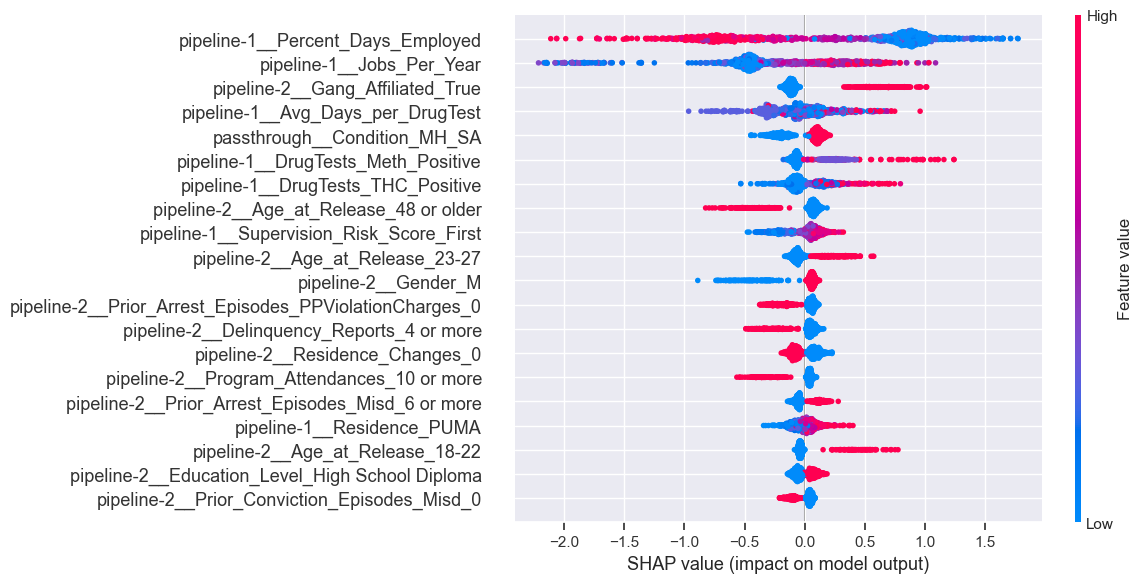

In [136]:
shap_figure = shap.summary_plot(xgb_shap_values, X_test_enc.iloc[ind], plot_size=[12,6])

We can see on the plot, for XGBoost model:

Low value of `Percent_Days_Employed`, true value of `Gang_Affiliated` `DrugTests_THC_Positive` `DrugTests_Meth_Positive` `Age_At_Release_23-27` `Age_At_Release_18-22`, high value of `Jobs_Per_Year` `Avg_Days_per_DrugTest` are the value of features that have large positive SHAP value, referring to SHAP documentation, it means those specific value of features have a big impact on the model to push it's prediction more towards positive class(which is recidivism). 

High value of `Percent_Days_Employed`, low value of `Jobs_Per_Year` `Supervison_Risk_Score_First`, true value of `Prior_Arrest_Episodes_PPViolationCharges_0` `Age_At_Release_48_or_older` `Delinquency_Reports_4 or more` `Program_Attendances_19 or more`, false value of `Gender_M`, middle low value of `Avg_Days_per_DrugTest` are the value of features that have large negative SHAP value, referring to SHAP documentation, it means those specific value of features have a big impact on the model to push it's prediction more towards negative class(which is no recidivism). 

In particularly, `Percent_Days_Employed` and `Jobs_Per_Year` are two most important features in the model because their distinct value(low and high or true or false) are scattered very widely, reach both very low and high SHAP value, which means their value can make both big negative and positive impact on the model prediction.

Other features value are more concentrate near 0, which means they have relatively small SHAP value. This indicate the value change in those features only bring little impact on model's prediction. So those features are less important for the model.

### Question 14: Explaining individual predictions using SHAP

Another powerful feature of SHAP is that it allows us to explain the impact of each feature on individual predictions. For example, we will be able to explain how the prediction for our hard sample was generated. Let's start by looking at the prediction for this sample given by the random forest model. **Is it correct?**

In [137]:
hard_sample_prediction_rf = rf_model.predict(hard_sample)
actual_res = y_test[106]

is_correct_rf = hard_sample_prediction_rf[0] == actual_res

print(f"Random Forest Prediction for Hard Sample is: {hard_sample_prediction_rf[0]}, the Actual result is: {actual_res}")
print(f"The prediction {'IS' if is_correct_rf else 'IS NOT'} correct")

Random Forest Prediction for Hard Sample is: True, the Actual result is: False
The prediction IS NOT correct


Let's look at the **force plot** for this particular prediction, by running the cell below:

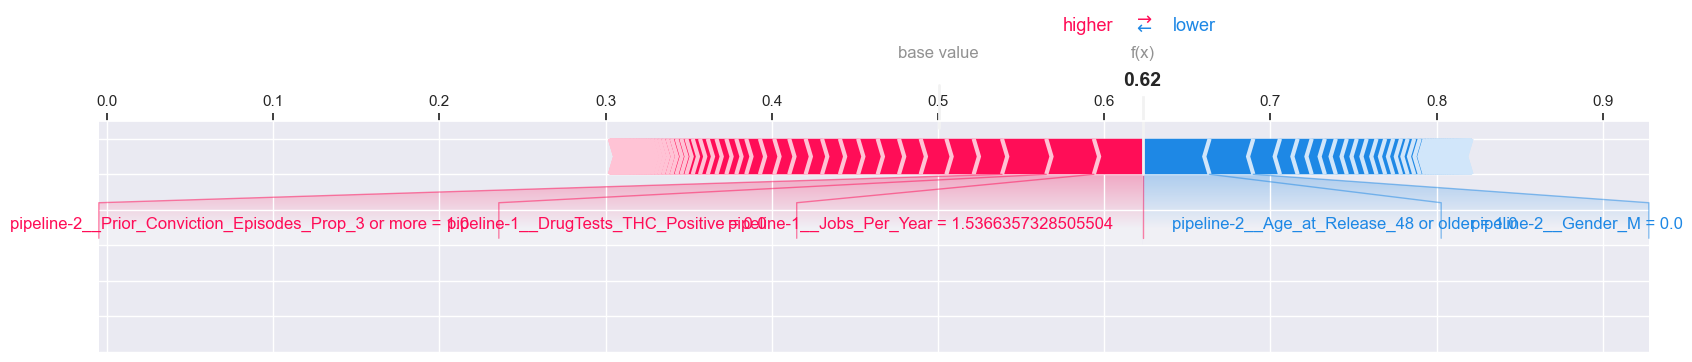

In [138]:
import shap

shap.force_plot(
    rf_explainer.expected_value[1],
    rf_shap_values[:,:,1][-1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
)

**Interpret the plot results,**, including the following:
- What contributed the most to the prediction?
- What countered the prediction the most?
- Can we tell, by looking at the plot, that this was a difficult prediction?

1. The prediction is higher than the base value, so it is positive. Among all the the red features that make value higher, we can see that the most significant positive contributor is `Jobs_Per_Year`.

2. Among all the the blue features that make value lower, we can see that the most significant negative contributor that counter the prediction is `Age_at_Release_48 or older`.

3. Yes, we can tell this was a difficult prediction. First, the prediction value f(x) is 0.62, which is close to the base value 0.5 so the classification is not confident. The closer a prediction is to the base value, the harder for the model to make a confident classification. Second, There's many feature both pushing the prediction value higher(positive features, red) and lower(negative features, blue). When roughly same amount of features having similar SHAP values are pulling the prediction in opposite directions, it indicates that there are conflicting signals in the data for the sample, which means the prediction is difficult to make.

Finally, **repeat the analysis and comment on the results of the individual predictions made on the hard sample by XGBoost and Decision Tree** (since we were not able to do the latter earlier).

In [139]:
hard_sample_prediction_xgb = xgboost_model.predict(hard_sample)
hard_sample_prediction_tree = tree_model.predict(hard_sample)

if (hard_sample_prediction_xgb[0] == 1):
    hard_sample_prediction_xgb = "True"
else:
    hard_sample_prediction_xgb = "False"

is_correct_xgb = hard_sample_prediction_xgb[0] == actual_res
is_correct_tree = hard_sample_prediction_tree[0] == actual_res

print(f"XGBoost for Hard Sample is: {hard_sample_prediction_xgb[0]}, the Actual result is: {actual_res}")
print(f"The prediction {'IS' if is_correct_xgb else 'IS NOT'} correct")
print(f"Decision Tree for Hard Sample is: {hard_sample_prediction_tree[0]}, the Actual result is: {actual_res}")
print(f"The prediction {'IS' if is_correct_tree else 'IS NOT'} correct")

XGBoost for Hard Sample is: T, the Actual result is: False
The prediction IS NOT correct
Decision Tree for Hard Sample is: True, the Actual result is: False
The prediction IS NOT correct


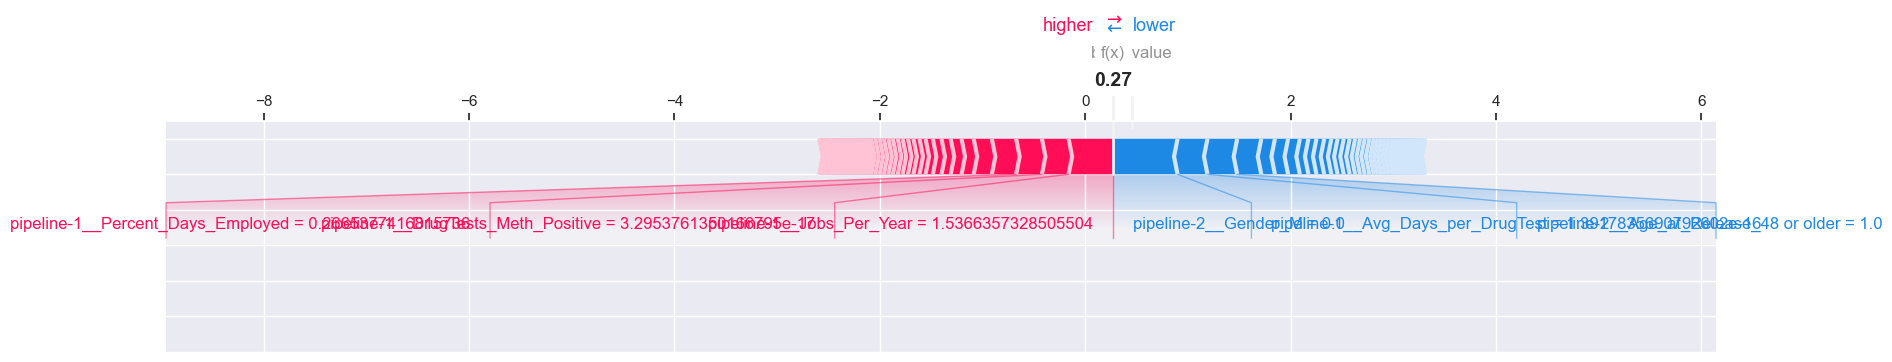

In [140]:
shap.force_plot(
    xgb_explainer.expected_value,
    xgb_shap_values[-1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
)

1. The prediction is higher than the base value, so it is positive. Among all the the red features that make value higher, we can see that the most significant positive contributor is `Jobs_Per_Year`.

2. Among all the the blue features that make value lower, we can see that the most significant negative contributor that counter the prediction is `Gender_M`.

3. Yes, we can tell this was a difficult prediction. First, the prediction value f(x) is 0.27, which is close to the base value 0 so the classification is not confident. Second, There's many feature both pushing the prediction value higher(positive features, red) and lower(negative features, blue). When roughly same amount of features having similar SHAP values are pulling the prediction in opposite directions, it indicates that there are conflicting signals in the data for the sample, which means the prediction is difficult to make.

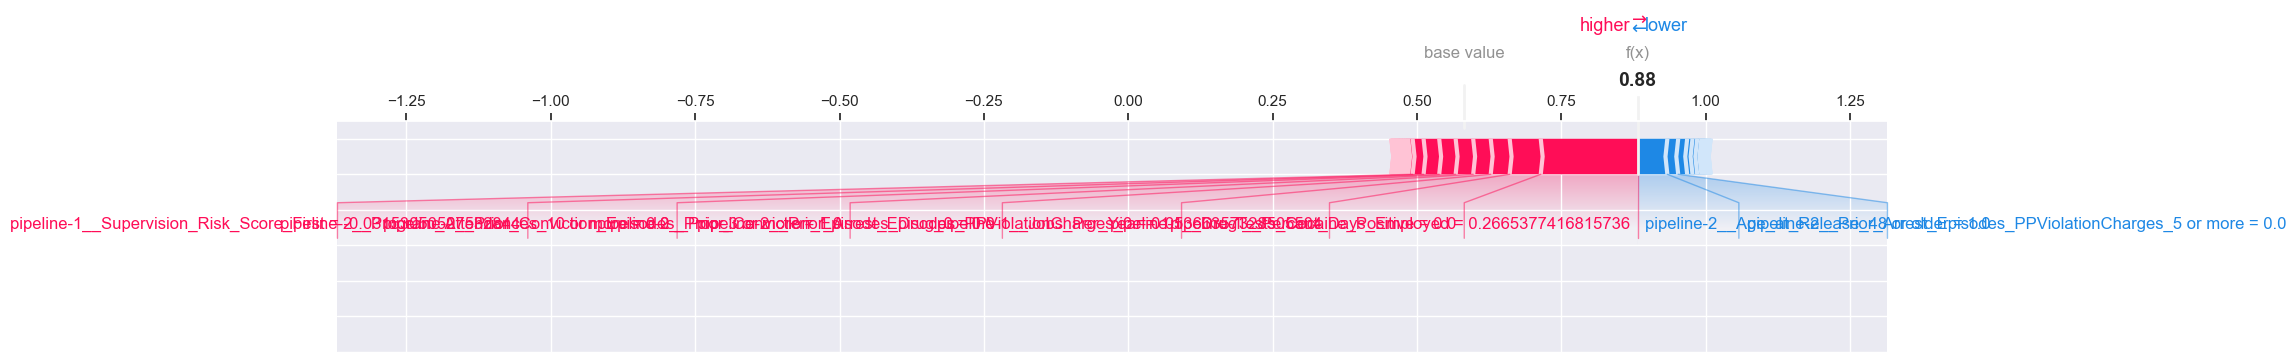

In [141]:
X_train_enc = pd.DataFrame(
    data=xgboost_model.named_steps['ct'].transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=xgboost_model.named_steps['ct'].transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

ind = np.random.choice(len(X_test_enc) - 1, 1000)  
ind = np.append(ind, 106) 

tree_explainer = shap.Explainer(tree_model[-1])  
tree_shap_values = tree_explainer.shap_values(X_test_enc.iloc[ind])
shap.force_plot(
    tree_explainer.expected_value[1],
    tree_shap_values[:,:,1][-1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
)

1. The prediction is higher than the base value, so it is positive. Among all the the red features that make value higher, we can see that the most significant positive contributor is `Jobs_Per_Year`.

2. Among all the the blue features that make value lower, we can see that the most significant negative contributor that counter the prediction is `Age_at_Release_48 or older`.

3. Mo, we cannot tell this was a difficult prediction. First, the prediction value f(x) is 0.88, which is relatively far away to the base value 0 so the classification is somehow confident. Second, There feature that pushing the prediction value higher(positive features, red) is clearly more than the feature that pushing the prediction value lower(negative features, blue). And the sum of positive features SHAP values is much more than that of the negative values, which indicate the prediction is not hard to make.

# Part 5: Final Evaluation:

### Question 15

Using **all the results collected so far** on accuracy, fairness and transparency of the 5 models, write your recommendation about what model, in your opinion, should be employed for this application (300 words max).

Based on the results across accuracy, fairness, and transparency, I recommend deploying the XGBoost model for this application. 

XGBoost consistently delivered strong performance across multiple metrics, including the highest test accuracy, recall, F1 score, and AUC, which shows its capability to reliably distinguish between individuals at risk of reoffending within three years. Its higher recall, while leading to more false positives, is crucial in this context because it prioritizes identifying individuals who may pose a risk, minimizing the chance of releasing someone likely to reoffend.

From a fairness perspective, XGBoost shows relatively balanced metrics across racial groups, though there are disparities in PPRD, like in all models. However, its FPRD on the test and training sets are the lowest among the models, reflecting that it does a better job of treating different racial groups equally regarding false accusations. Fairness is essential in applications like parole decisions, and XGBoost demonstrates a balance between minimizing harm to society and avoiding overly severe predictions.

Though XGBoost is non-inherently interpretable model. The combination of Permutation Feature Importance and SHAP for interpreting the model, feature importance and impact to the prediction supports XGBoost. These methods revealed that the key features driving the predictions are understandable and align with domain knowledge. This interpretability makes the model more trustworthy for deployment in sensitive contexts like criminal justice.

In conclusion, while all models have trade-offs, XGBoost offers the best balance of predictive power, fairness, and acceptable interpretability for this application. Its superior performance in critical areas makes it the strongest candidate for deployment.

# Final thoughts

1) If you have completed this assignment in a group, please write a detailed description of how you divided the work and how you helped each other completing it:

We didn't really divide the work, we did all the questions together, gathering thoughts and organizing sentences. 

2) Have you used ChatGPT or a similar Large Language Model (LLM) to complete this homework? Please describe how you used the tool. We will never deduct points for using LLMs for completing homework assignments, but this helps us understand how you are using the tool and advise you in case we believe you are using it incorrectly.

Yes , we used ChatGPT to explain the concepts we feel confused, so that we can understand the question better.

3) Have you struggled with some parts (or all) of this homework? Do you have pending questions you would like to ask? Write them down here!

struggled with the SHAP part, especially for the coding part.